In [1]:
import gzip
import shutil
from pathlib import Path
from urllib.request import urlretrieve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter
from datetime import timedelta
from time import time

## Get NASDAQ ITCH Data from FTP Server

### Set Data paths

In [34]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [3]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/'
SOURCE_FILE = '03292018.NASDAQ_ITCH50.gz'

### Download & unzip

In [4]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    filename = data_path/ url.split('/')[-1]
    unzipped = filename.stem + '.bin'
    if not filename.exists():
        urlretrieve(url, filename)
    if not (data_path / unzipped).exists():
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    return unzipped

In [5]:
file_name = may_be_download(FTP_URL + SOURCE_FILE)
date = file_name.split('.')[0]

## ITCH Format Settings

In [6]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [7]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [8]:
formats = {
    ('integer', 2): 'H',
    ('integer', 4): 'I',
    ('integer', 6): '6s',
    ('integer', 8): 'Q',
    ('alpha', 1)  : 's',
    ('alpha', 2)  : '2s',
    ('alpha', 4)  : '4s',
    ('alpha', 8)  : '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

### Get message specification

In [9]:
# Get ITCH specs and create formatting (type, length) tuples
specs = pd.read_csv('message_specs/message_types.csv')
specs['formats'] = specs[['value', 'length']].apply(tuple, axis=1).map(formats)

In [10]:
# Extract formatting for alphanumerical fields
alpha_fields = specs[specs.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

In [11]:
# Generate message classes as named tuples and format strings
message_fields, fstring = {}, {}
for t, message in specs.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

In [12]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

## Process Messages

In [13]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)

In [14]:
messages = {}
message_count = 0
message_type_counter = Counter()

In [15]:
start = time()
with (data_path / file_name).open('rb') as data:
    while True:
        
        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')
        
        # create data structure to capture result
        if not messages.get(message_type):
            messages[message_type] = []

        message_type_counter.update([message_type])

        # read & store message
        record = data.read(message_size - 1)
        message = message_fields[message_type]._make(unpack(fstring[message_type], record))
        messages[message_type].append(message)
        
        # deal with system events
        if message_type == 'S':
            timestamp = int.from_bytes(message.timestamp, byteorder='big')
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print('\t{0}\t{1:,.0f}'.format(timedelta(seconds=timestamp * 1e-9),
                                         message_count))
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break

        message_count += 1
        if message_count % 2.5e7 == 0:
            timestamp = int.from_bytes(message.timestamp, byteorder='big')
            print('\t{0}\t{1:,.0f}\t{2}'.format(timedelta(seconds=timestamp * 1e-9),
                                                message_count,
                                                timedelta(seconds=time() - start)))
            store_messages(messages)
            messages = {}
            
        
print(timedelta(seconds=time() - start))


 Start of Messages
	3:02:35.269387	0

 Start of System Hours
	4:00:00.000184	227,610

 Start of Market Hours
	9:30:00.000032	11,529,493
	9:42:03.570818	25,000,000	0:01:49.134681
	10:08:32.211701	50,000,000	0:05:09.018245
	10:37:28.259358	75,000,000	0:08:21.454919
	11:07:46.775165	100,000,000	0:11:33.356573
	11:38:49.824403	125,000,000	0:14:49.758422
	12:16:49.624628	150,000,000	0:18:04.423731
	13:06:45.578658	175,000,000	0:21:20.837394
	13:54:46.034294	200,000,000	0:24:34.282908
	14:34:24.393325	225,000,000	0:27:50.744248
	15:11:56.187078	250,000,000	0:31:06.852861
	15:39:44.531785	275,000,000	0:34:24.335833
	15:57:26.138215	300,000,000	0:37:44.113658

 End of Market Hours
	16:00:00.000112	306,911,501

 End of System Hours
	20:00:00.000019	309,491,361

 End of Messages
	20:05:00.000035	309,535,654
0:40:21.432441


## Summarize Trading Day

### Trading Message Frequency

In [18]:
message_labels = pd.read_csv('message_specs/message_labels.csv')
message_labels.head()

,message_type,name
0,S,system_event
1,R,stock_directory
2,H,stock_trading_action
3,Y,reg_sho_short_sale_price_test_restricted_indic...
4,L,market_participant_position


In [19]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
print(counter)

                                        Message Type   # Trades
A                                  add_order_no_mpid  136522761
D                                       order_delete  133811007
U                                      order_replace   21941015
E                                     order_executed    6687379
X                                       order_cancel    5088959
F                                     add_order_mpid    2718602
I                                               noii    1242461
P                                              trade    1120861
L                        market_participant_position     201931
C                          order_executed_with_price     157442
Q                                        cross_trade      17233
Y  reg_sho_short_sale_price_test_restricted_indic...       8716
H                               stock_trading_action       8649
R                                    stock_directory       8613
J                                luld_au

In [20]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

### Top Equities by Traded Value

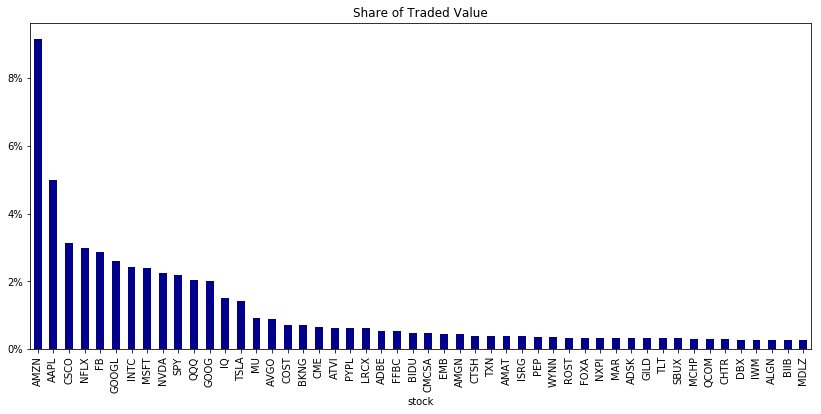

In [21]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)
trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Build Order Book

In [22]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

### Get all messages for given stock

In [23]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [24]:
messages = get_messages(date=date)
messages.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357395 entries, 0 to 1357394
Data columns (total 9 columns):
timestamp             1357395 non-null datetime64[ns]
buy_sell_indicator    1252142 non-null float64
shares                1341758 non-null float64
price                 1341758 non-null float64
type                  1357395 non-null object
executed_shares       57831 non-null float64
execution_price       1133 non-null float64
shares_replaced       15091 non-null float64
price_replaced        15091 non-null float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 93.2+ MB


In [25]:
with pd.HDFStore(order_book_store) as store:
    key = '{}/messages'.format(stock)
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: order_book.h5
/AAPL/messages            frame        (shape->[1357395,9])


### Combine Trading Records

In [26]:
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)


In [27]:
trades = get_trades(messages)
print(trades.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67699 entries, 2018-03-29 04:03:47.047627992 to 2018-03-29 19:59:09.856377406
Data columns (total 3 columns):
shares    67699 non-null int64
price     67699 non-null int64
cross     67699 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB
None


In [28]:
with pd.HDFStore(order_book_store) as store:
    store.put('{}/trades'.format(stock), trades)

### Create Orders

In [29]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [30]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = '{}/{}'.format(stock, order_dict[buysell])
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

In [31]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print('{:,.0f}\t\t{}'.format(i, timedelta(seconds=time() - start)))
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		0:00:27.887683
200,000		0:00:36.111832
300,000		0:00:36.785264
400,000		0:00:39.715301
500,000		0:00:37.832533
600,000		0:00:39.072831
700,000		0:00:39.357666
800,000		0:00:39.408049
900,000		0:00:39.724151
1,000,000		0:00:39.658365
1,100,000		0:00:40.561551
1,200,000		0:00:41.503466
1,300,000		0:00:51.733224


In [32]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    606940
D    551188
X      7781
P     12612
E     53952
F      3486
U     15091
C      1092
dtype: int64


In [33]:
with pd.HDFStore('order_book.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->55188208,ncols->2,indexers->[index])
/AAPL/messages            frame        (shape->[1357395,9])                                        
/AAPL/sell                frame_table  (typ->appendable,nrows->56808426,ncols->2,indexers->[index])
/AAPL/trades              frame        (shape->[67699,3])                                          
